## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [ ]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

Mounted at /content/drive


Importing required libraries

In [ ]:
import os, gc
import random
import shutil
import time, datetime
from thop import vision, profile, clever_format
from flopth import flopth
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cuda


Setting up logger and directories

In [ ]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/


## Base CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=30
n_class=10

prim_caps_channels=10
prim_caps_dim=8
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
base_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                 model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                 prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

base_capsnet_cifar10_model.name = 'base_capsnet_cifar10_model'
base_capsnet_cifar10_model = base_capsnet_cifar10_model.to(device)
base_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

### Training

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  base_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/06 02:44:23 AM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5779, Top 1 Acc=9.38, Top 5 Acc=45.31
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5779, Top 1 Acc=9.38, Top 5 Acc=45.31
02/06 02:44:28 AM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4432, Top 1 Acc=33.82, Top 5 Acc=80.41
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4432, Top 1 Acc=33.82, Top 5 Acc=80.41
02/06 02:44:33 AM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4183, Top 1 Acc=38.43, Top 5 Acc=84.31
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4183, Top 1 Acc=38.43, Top 5 Acc=84.31
02/06 02:44:37 AM | base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4023, Top 1 Acc=41.31, Top 5 Acc=86.38
INFO:capsnet:base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.402

CPU times: user 29min 49s, sys: 1min 34s, total: 31min 24s
Wall time: 31min 46s


### Plots for losses and accuracies

In [ ]:
base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = base_capsnet_cifar10_model['epoch_accuracy']

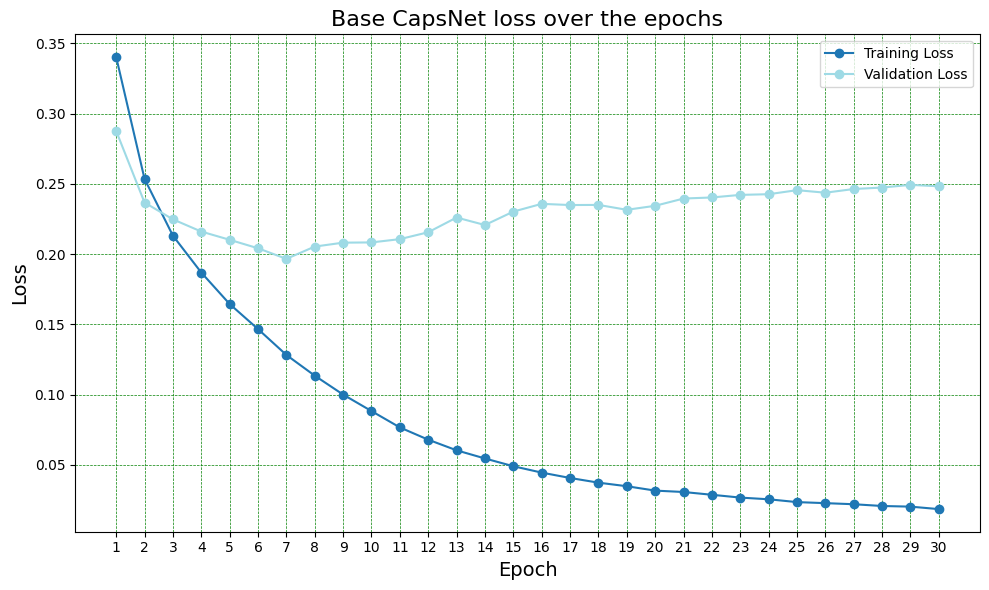

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Base CapsNet loss over the epochs')

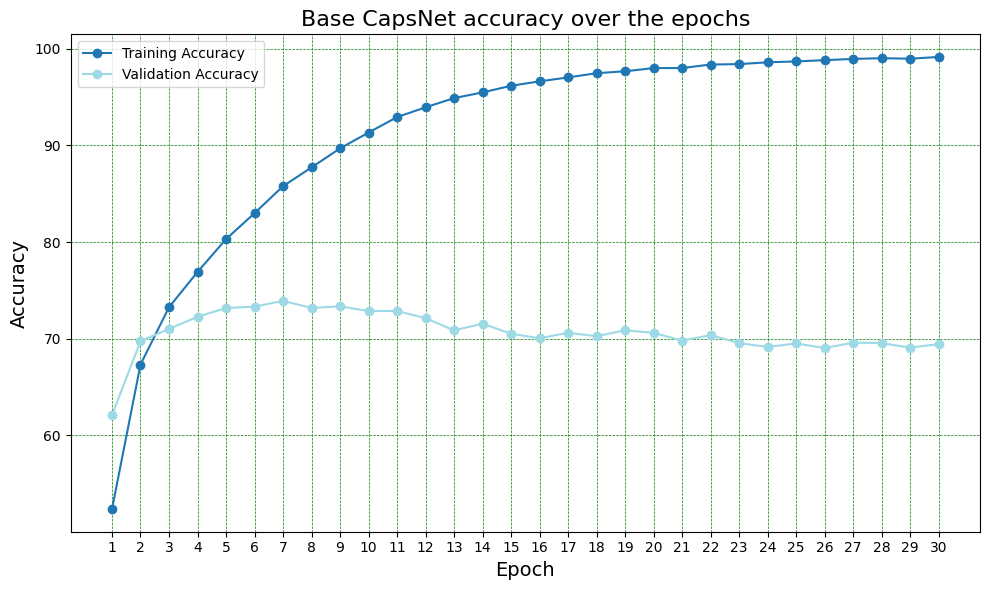

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Base CapsNet accuracy over the epochs')

### Training with CCM loss

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=30
n_class=10

prim_caps_channels=10
prim_caps_dim=8
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                     model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                     prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                     extract_feature_maps=True)

best_trained_base_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_model.pt',
                                             map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
%%time
best_trained_ccm_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                      base_capsnet_cifar10_ccm_model,
                                                      criterion,
                                                      train_loader,
                                                      test_loader,
                                                      CIFAR10_TRAIN_DIR,
                                                      logger,
                                                      calc_ccm=True,
                                                      device=device)

02/06 03:16:12 AM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/782), Loss=0.0842, Top 1 Acc=90.62, Top 5 Acc=100.00
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(0/782), Loss=0.0842, Top 1 Acc=90.62, Top 5 Acc=100.00
02/06 03:16:17 AM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/782), Loss=0.0896, Top 1 Acc=89.59, Top 5 Acc=99.90
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(64/782), Loss=0.0896, Top 1 Acc=89.59, Top 5 Acc=99.90
02/06 03:16:23 AM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(128/782), Loss=0.0909, Top 1 Acc=89.41, Top 5 Acc=99.88
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(128/782), Loss=0.0909, Top 1 Acc=89.41, Top 5 Acc=99.88
02/06 03:16:28 AM | base_capsnet_cifar10_ccm_model Training - Epoch=1, Iteration=(192/782), Loss=0.0906, Top 1 Acc=89.43, Top 5 Acc=99.87
INFO:capsnet:base_capsnet_cifar10_ccm_model Training - Epoc

CPU times: user 32min 7s, sys: 1min 39s, total: 33min 47s
Wall time: 34min 4s


### CCM and CI score calculation

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=30
n_class=10

prim_caps_channels=10
prim_caps_dim=8
n_caps_layers=0

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:01<00:00, 105655147.99it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                     model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                     prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers,
                                                     extract_feature_maps=True)

best_trained_base_capsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_ccm_model.pt',
                                                 map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_ccm_model['model_state_dict'])

base_capsnet_cifar10_ccm_model.name = 'base_capsnet_cifar10_ccm_model'
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

Extract Correlation Coefficient Matrix

In [ ]:
%%time
base_capsnet_cifar10_ccm_model.eval()

n_conv_layers = 4
layer_ccm_list = [ [] for _ in range(n_conv_layers) ]
layer_mean_ccm_list = []

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        _, _, batch_layer_feature_maps = base_capsnet_cifar10_ccm_model(images)

        for indx, batch_feature_maps in enumerate(batch_layer_feature_maps):
            _, batch_ccm = ccmp.calc_ccm_loss(batch_feature_maps)
            layer_ccm_list[indx].append(batch_ccm.detach().cpu())

        torch.cuda.empty_cache()

for i in range(n_conv_layers):
    layer_mean_ccm_list.append(torch.mean(torch.stack(layer_ccm_list[i]), dim=0))

ccmp.save_ccm(layer_mean_ccm_list, CIFAR10_TRAIN_DIR, base_capsnet_cifar10_ccm_model.name+'_ccm')

base_capsnet_cifar10_ccm_model_ccm saved
CPU times: user 20.8 s, sys: 2.29 s, total: 23.1 s
Wall time: 25.3 s


Channel Importance Scores

In [ ]:
%%time
base_capsnet_cifar10_ccm_model.eval()

n_conv_layers = 4
layer_ci_list = [ [] for _ in range(n_conv_layers) ]

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        _, _, batch_layer_feature_maps = base_capsnet_cifar10_ccm_model(images)

        for indx, batch_feature_maps in enumerate(batch_layer_feature_maps):
            batch_ci_score = ccmp.ci_score(batch_feature_maps)
            layer_ci_list[indx].append(batch_ci_score.detach().cpu().numpy())

        torch.cuda.empty_cache()

    layer_mean_ci_list = []

    for i in range(n_conv_layers):
        layer_mean_ci_list.append(np.mean(layer_ci_list[i], axis=0))

    np.save(CIFAR10_TRAIN_DIR+base_capsnet_cifar10_ccm_model.name+'_ci_scores.npy', np.asarray(layer_mean_ci_list, dtype=object))

CPU times: user 6min 41s, sys: 3.02 s, total: 6min 44s
Wall time: 6min 46s


### Pruning

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=30
n_class=10

prim_caps_channels=10
prim_caps_dim=8
n_caps_layers=0

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:12<00:00, 13766011.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
pretrained_base_capsnet_cifar10_ccm_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                model_conv_config=model_conv_config,
                                                                prim_caps_channels=prim_caps_channels,
                                                                prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_trained_base_capsnet_ccm_model = torch.load(CIFAR10_TRAIN_DIR+'Best_base_capsnet_cifar10_ccm_model.pt',
                                                 map_location=device)

pretrained_base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_base_capsnet_ccm_model['model_state_dict'])

pretrained_base_capsnet_cifar10_ccm_model = pretrained_base_capsnet_cifar10_ccm_model.to(device)
pretrained_base_capsnet_cifar10_ccm_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)

In [ ]:
layers_to_prune_dict = {'conv_layer_1':0,
                        'conv_layer_2':1,
                        'conv_layer_3':2,
                        'primary_caps':3 }

base_capsnet_cifar10_ccm_model_ci_scores = np.load(CIFAR10_TRAIN_DIR+'base_capsnet_cifar10_ccm_model_ci_scores.npy', allow_pickle=True)
# base_capsnet_cifar10_ccm_model_ccm = ccmp.load_ccm(CIFAR10_TRAIN_DIR, 'base_capsnet_cifar10_ccm_model_ccm')

#### 12.5% Pruning

In [ ]:
prune_threshold = 0.125

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_12pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_12pc_base_capsnet_cifar10_model.name = 'pruned_12pc_base_capsnet_cifar10_model'
pruned_12pc_base_capsnet_cifar10_model = pruned_12pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(32, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_12pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_12pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/06 02:56:50 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7005, Top 1 Acc=10.94, Top 5 Acc=48.44
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7005, Top 1 Acc=10.94, Top 5 Acc=48.44
02/06 02:56:55 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4332, Top 1 Acc=40.46, Top 5 Acc=83.29
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4332, Top 1 Acc=40.46, Top 5 Acc=83.29
02/06 02:57:00 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3828, Top 1 Acc=48.83, Top 5 Acc=87.89
INFO:capsnet:pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3828, Top 1 Acc=48.83, Top 5 Acc=87.89
02/06 02:57:06 PM | pruned_12pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3571, Top 1 Acc=53.03, Top 5 Acc=89.93
INFO:

CPU times: user 29min 18s, sys: 1min 31s, total: 30min 50s
Wall time: 31min 6s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_12pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_12pc_base_capsnet_cifar10_model['epoch_accuracy']

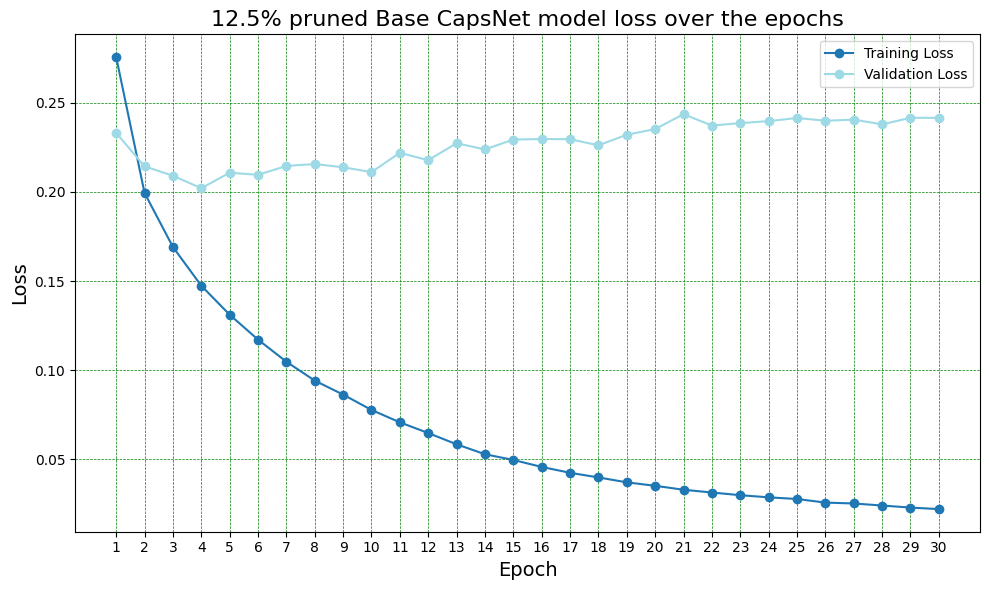

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '12.5% pruned Base CapsNet model loss over the epochs')

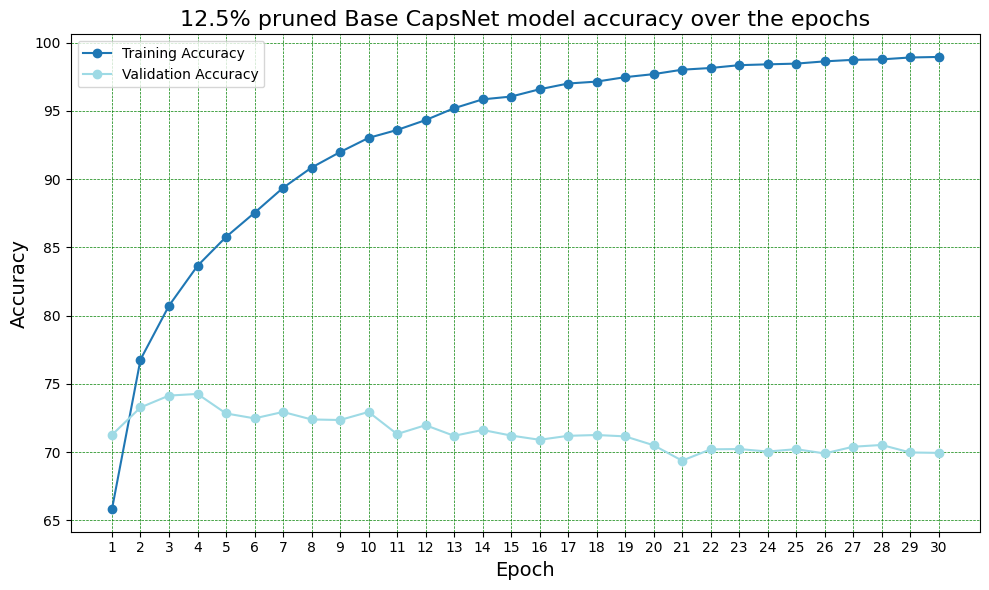

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '12.5% pruned Base CapsNet model accuracy over the epochs')

#### 25% Pruning

In [ ]:
prune_threshold = 0.25

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_25pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_25pc_base_capsnet_cifar10_model.name = 'pruned_25pc_base_capsnet_cifar10_model'
pruned_25pc_base_capsnet_cifar10_model = pruned_25pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_25pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_25pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/06 03:27:56 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6469, Top 1 Acc=6.25, Top 5 Acc=40.62
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6469, Top 1 Acc=6.25, Top 5 Acc=40.62
02/06 03:28:00 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4071, Top 1 Acc=43.56, Top 5 Acc=84.76
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4071, Top 1 Acc=43.56, Top 5 Acc=84.76
02/06 03:28:06 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3659, Top 1 Acc=51.05, Top 5 Acc=88.77
INFO:capsnet:pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3659, Top 1 Acc=51.05, Top 5 Acc=88.77
02/06 03:28:10 PM | pruned_25pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3398, Top 1 Acc=55.36, Top 5 Acc=90.76
INFO:ca

CPU times: user 29min 14s, sys: 1min 33s, total: 30min 48s
Wall time: 31min 7s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_25pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_25pc_base_capsnet_cifar10_model['epoch_accuracy']

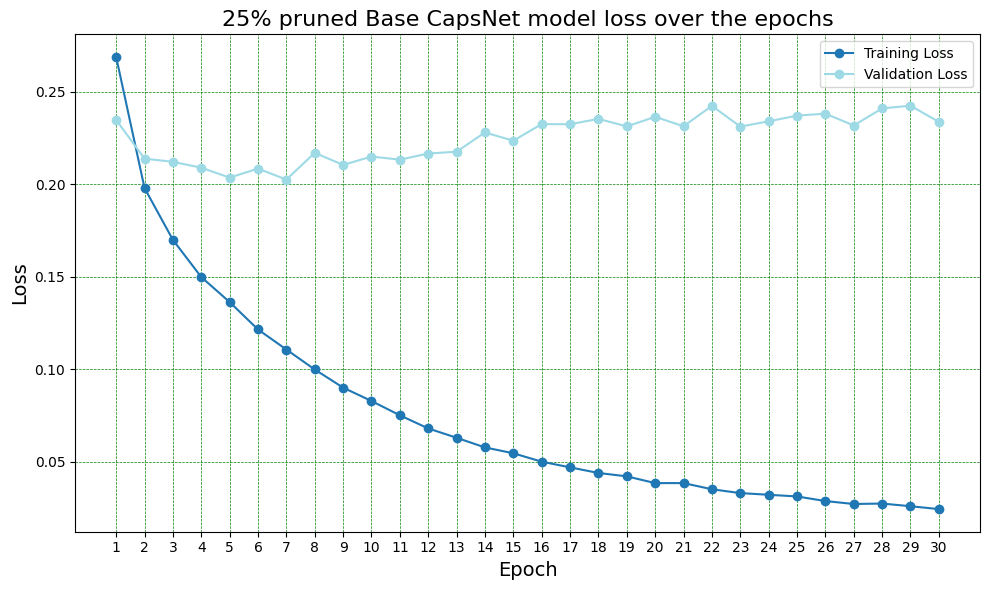

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '25% pruned Base CapsNet model loss over the epochs')

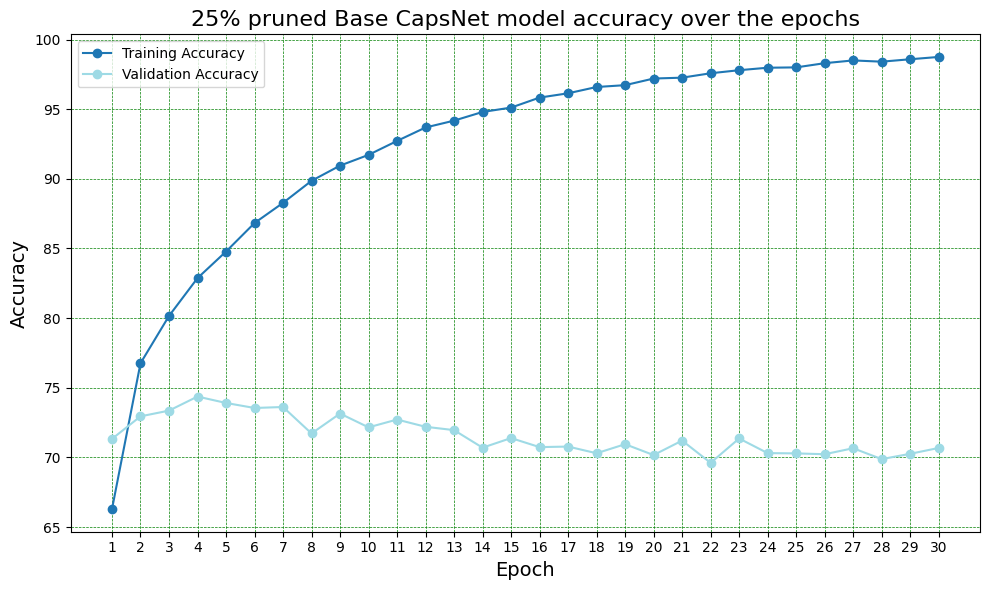

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '25% pruned Base CapsNet model accuracy over the epochs')

#### 37.5% Pruning

In [ ]:
prune_threshold = 0.375

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_37pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_37pc_base_capsnet_cifar10_model.name = 'pruned_37pc_base_capsnet_cifar10_model'
pruned_37pc_base_capsnet_cifar10_model = pruned_37pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(32, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(56, 56, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_37pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_37pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/06 03:59:05 PM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5915, Top 1 Acc=7.81, Top 5 Acc=48.44
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5915, Top 1 Acc=7.81, Top 5 Acc=48.44
02/06 03:59:10 PM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4038, Top 1 Acc=43.73, Top 5 Acc=85.91
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4038, Top 1 Acc=43.73, Top 5 Acc=85.91
02/06 03:59:15 PM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3597, Top 1 Acc=51.96, Top 5 Acc=89.74
INFO:capsnet:pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3597, Top 1 Acc=51.96, Top 5 Acc=89.74
02/06 03:59:19 PM | pruned_37pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3376, Top 1 Acc=55.53, Top 5 Acc=91.38
INFO:ca

CPU times: user 28min 33s, sys: 1min 33s, total: 30min 7s
Wall time: 30min 20s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_37pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_37pc_base_capsnet_cifar10_model['epoch_accuracy']

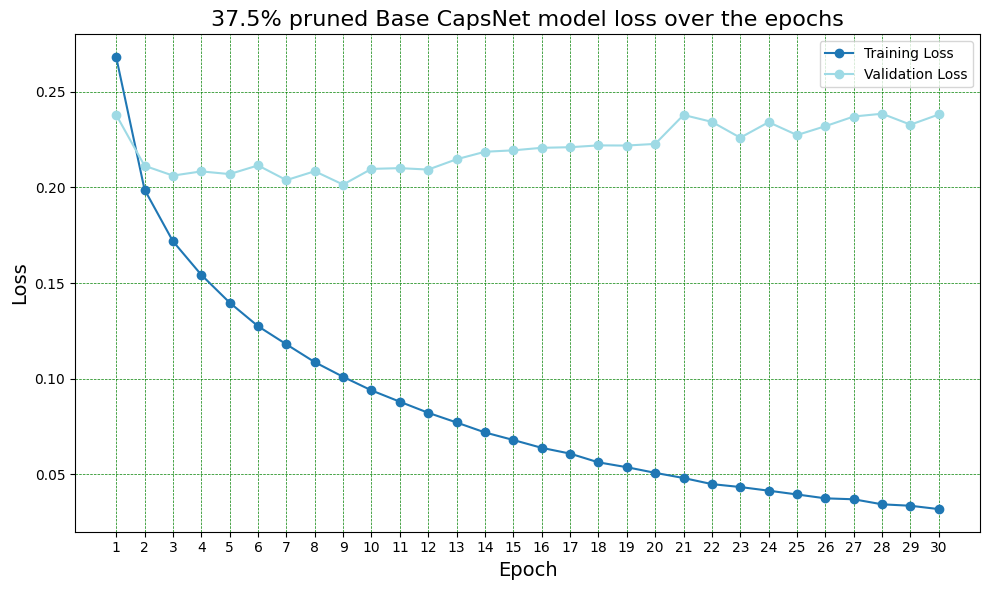

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '37.5% pruned Base CapsNet model loss over the epochs')

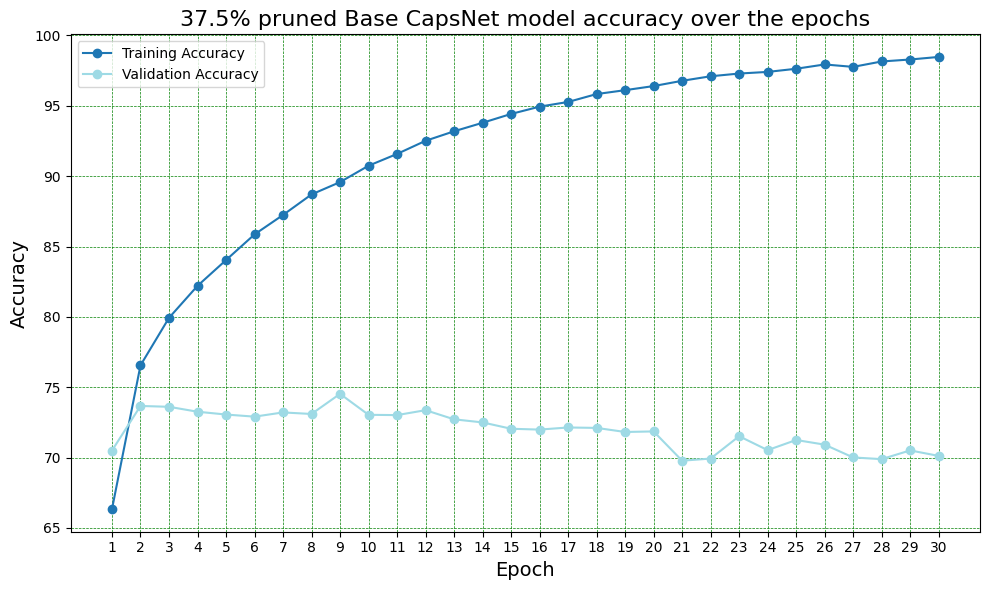

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '37.5% pruned Base CapsNet model accuracy over the epochs')

#### 50% Pruning

In [ ]:
prune_threshold = 0.50

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_50pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_50pc_base_capsnet_cifar10_model.name = 'pruned_50pc_base_capsnet_cifar10_model'
pruned_50pc_base_capsnet_cifar10_model = pruned_50pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(24, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(40, 40, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_50pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_50pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/06 04:29:26 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5589, Top 1 Acc=10.94, Top 5 Acc=42.19
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5589, Top 1 Acc=10.94, Top 5 Acc=42.19
02/06 04:29:31 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.3882, Top 1 Acc=45.77, Top 5 Acc=87.81
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.3882, Top 1 Acc=45.77, Top 5 Acc=87.81
02/06 04:29:36 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3486, Top 1 Acc=53.06, Top 5 Acc=90.87
INFO:capsnet:pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3486, Top 1 Acc=53.06, Top 5 Acc=90.87
02/06 04:29:40 PM | pruned_50pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3264, Top 1 Acc=56.84, Top 5 Acc=92.25
INFO:

CPU times: user 27min 21s, sys: 1min 33s, total: 28min 55s
Wall time: 29min 8s


##### Plots for losses and accuracies

In [ ]:
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_50pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_50pc_base_capsnet_cifar10_model['epoch_accuracy']

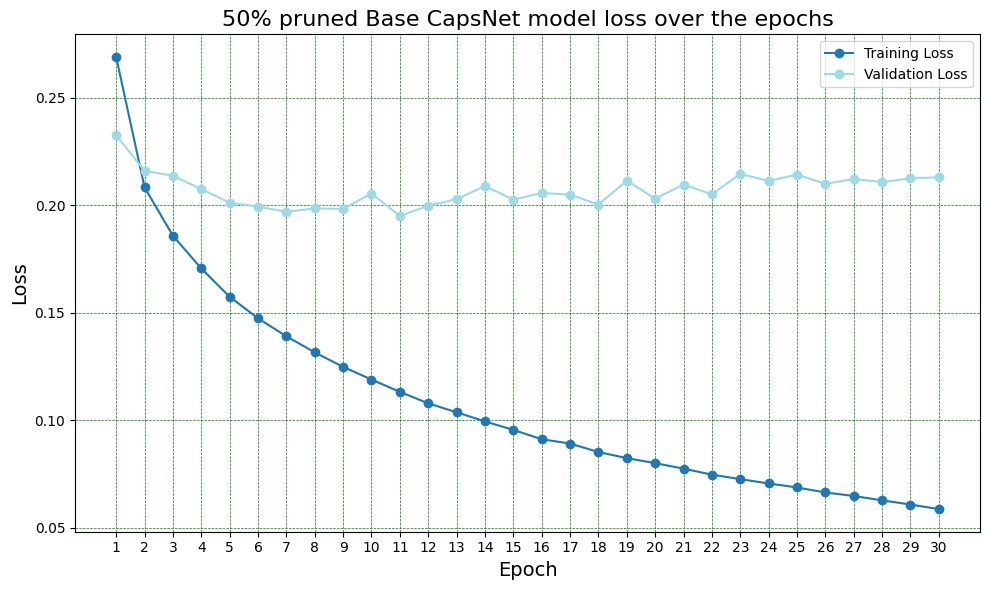

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '50% pruned Base CapsNet model loss over the epochs')

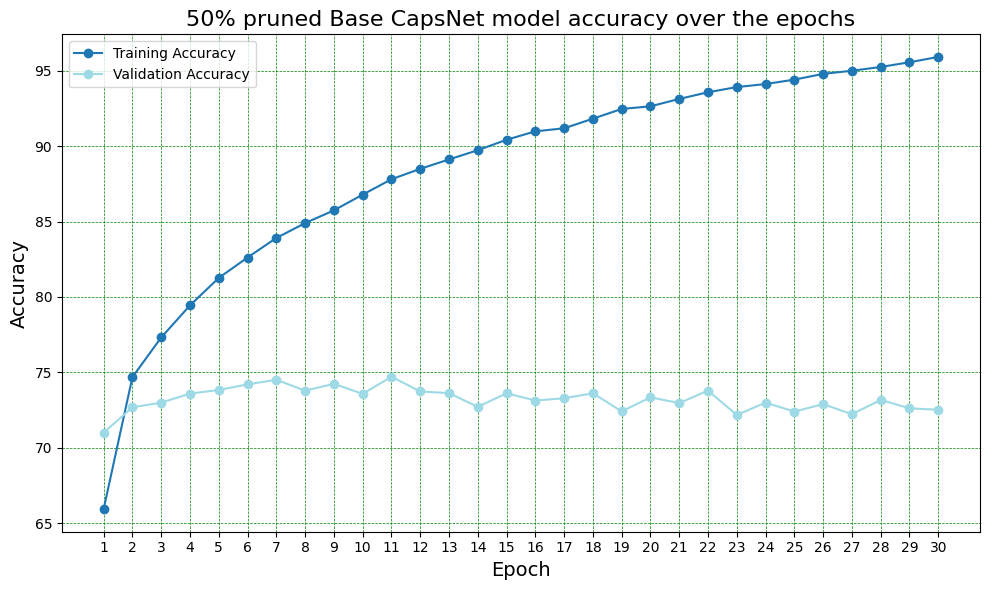

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '50% pruned Base CapsNet model accuracy over the epochs')

#### 60% Pruning

In [ ]:
prune_threshold = 0.60

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_60pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_60pc_base_capsnet_cifar10_model.name = 'pruned_60pc_base_capsnet_cifar10_model'
pruned_60pc_base_capsnet_cifar10_model = pruned_60pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_60pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_60pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/06 04:58:36 PM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5666, Top 1 Acc=10.94, Top 5 Acc=48.44
INFO:capsnet:pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5666, Top 1 Acc=10.94, Top 5 Acc=48.44
02/06 04:58:40 PM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4128, Top 1 Acc=39.59, Top 5 Acc=85.75
INFO:capsnet:pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4128, Top 1 Acc=39.59, Top 5 Acc=85.75
02/06 04:58:45 PM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3735, Top 1 Acc=47.38, Top 5 Acc=89.44
INFO:capsnet:pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3735, Top 1 Acc=47.38, Top 5 Acc=89.44
02/06 04:58:49 PM | pruned_60pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3502, Top 1 Acc=51.73, Top 5 Acc=91.23
INFO:

CPU times: user 27min 18s, sys: 1min 35s, total: 28min 54s
Wall time: 29min 16s


#####Plots for losses and accuracies

In [ ]:
trained_pruned_60pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_60pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_60pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_60pc_base_capsnet_cifar10_model['epoch_accuracy']

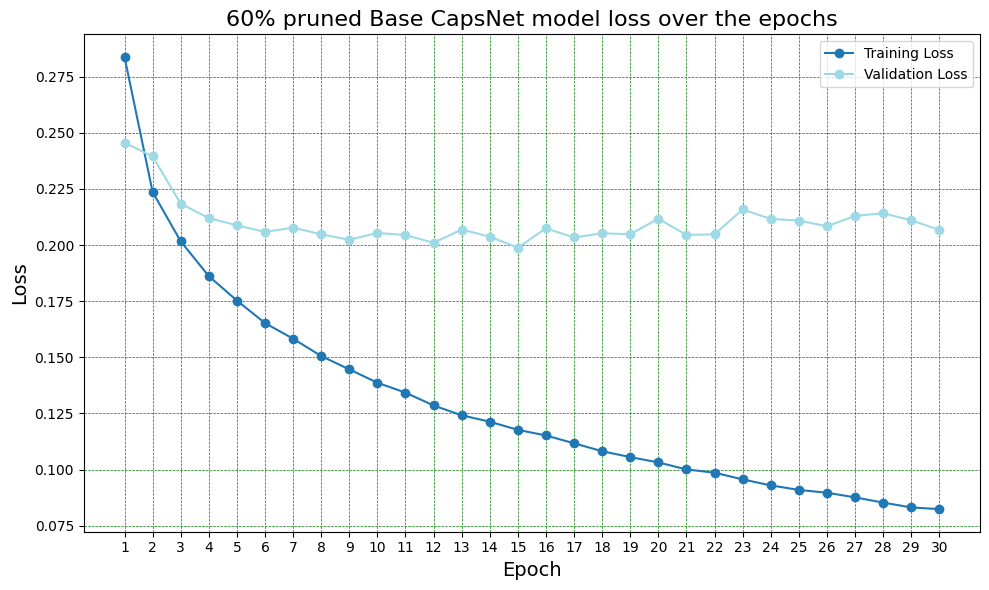

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '60% pruned Base CapsNet model loss over the epochs')

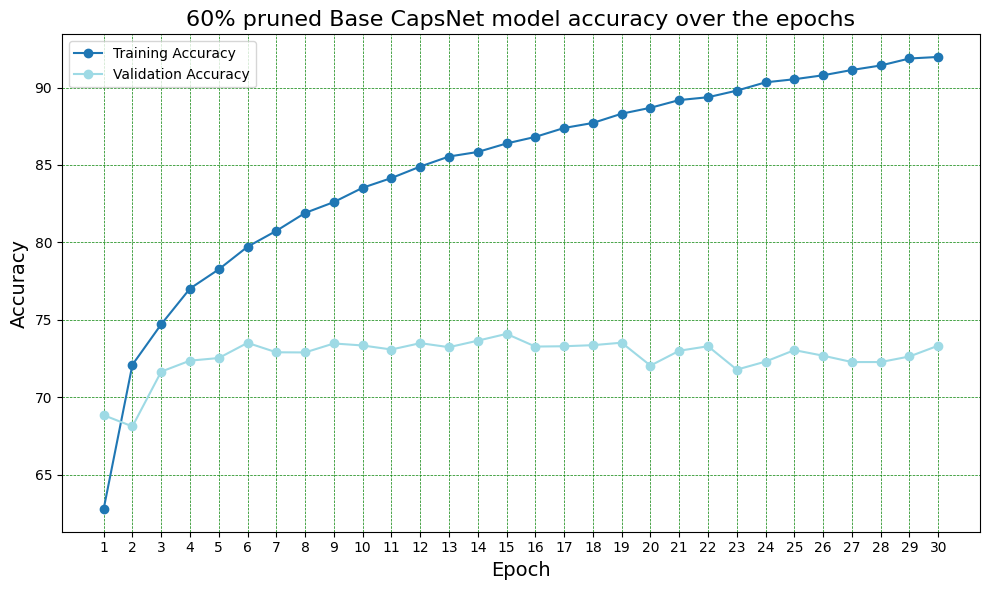

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '60% pruned Base CapsNet model accuracy over the epochs')

#### 75% Pruning

In [ ]:
prune_threshold = 0.75

channels_to_preserve = ccmp.get_channels_to_preserve(prune_threshold, base_capsnet_cifar10_ccm_model_ci_scores,
                                                     prim_caps_dim=prim_caps_dim, layers_to_prune=layers_to_prune_dict)

pruned_75pc_base_capsnet_cifar10_model = ccmp.prune_capsnet(pretrained_base_capsnet_cifar10_ccm_model,
                                                            model_conv_config_dict=model_conv_config, n_class=n_class,
                                                            n_caps_layers=n_caps_layers, prim_caps_dim=prim_caps_dim,
                                                            model_layers_to_prune=layers_to_prune_dict.keys(),
                                                            preserved_channels_dict=channels_to_preserve, device=device)

pruned_75pc_base_capsnet_cifar10_model.name = 'pruned_75pc_base_capsnet_cifar10_model'
pruned_75pc_base_capsnet_cifar10_model = pruned_75pc_base_capsnet_cifar10_model.to(device)

Pruned Model: CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(12, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2))
  )
  (class_caps): CapsLayer(
    (routing): RoutingByAggreement()
  )
)


##### Model Fine Tuning

In [ ]:
%%time
best_pruned_75pc_base_capsnet_path, _, _ = mtt.train_capsnet(n_epochs,
                                                             pruned_75pc_base_capsnet_cifar10_model,
                                                             criterion,
                                                             train_loader,
                                                             test_loader,
                                                             CIFAR10_TRAIN_DIR,
                                                             logger,
                                                             device=device)

02/06 05:27:54 PM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6338, Top 1 Acc=4.69, Top 5 Acc=42.19
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6338, Top 1 Acc=4.69, Top 5 Acc=42.19
02/06 05:27:58 PM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4225, Top 1 Acc=37.69, Top 5 Acc=85.62
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4225, Top 1 Acc=37.69, Top 5 Acc=85.62
02/06 05:28:02 PM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3838, Top 1 Acc=44.94, Top 5 Acc=89.16
INFO:capsnet:pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.3838, Top 1 Acc=44.94, Top 5 Acc=89.16
02/06 05:28:07 PM | pruned_75pc_base_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3606, Top 1 Acc=49.30, Top 5 Acc=90.77
INFO:ca

CPU times: user 26min 16s, sys: 1min 33s, total: 27min 49s
Wall time: 28min 1s


#####Plots for losses and accuracies

In [ ]:
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = trained_pruned_75pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = trained_pruned_75pc_base_capsnet_cifar10_model['epoch_accuracy']

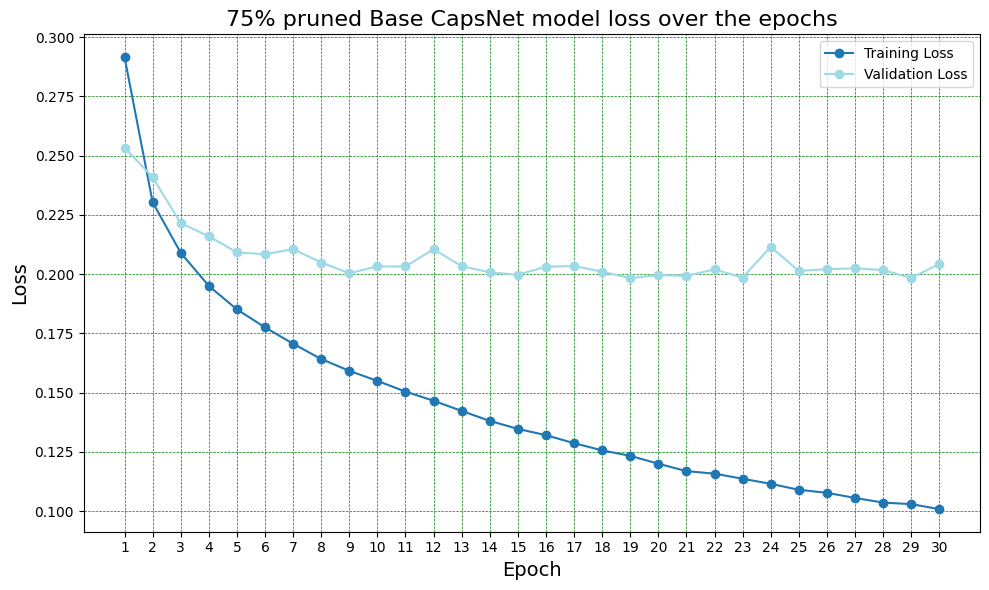

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      '75% pruned Base CapsNet model loss over the epochs')

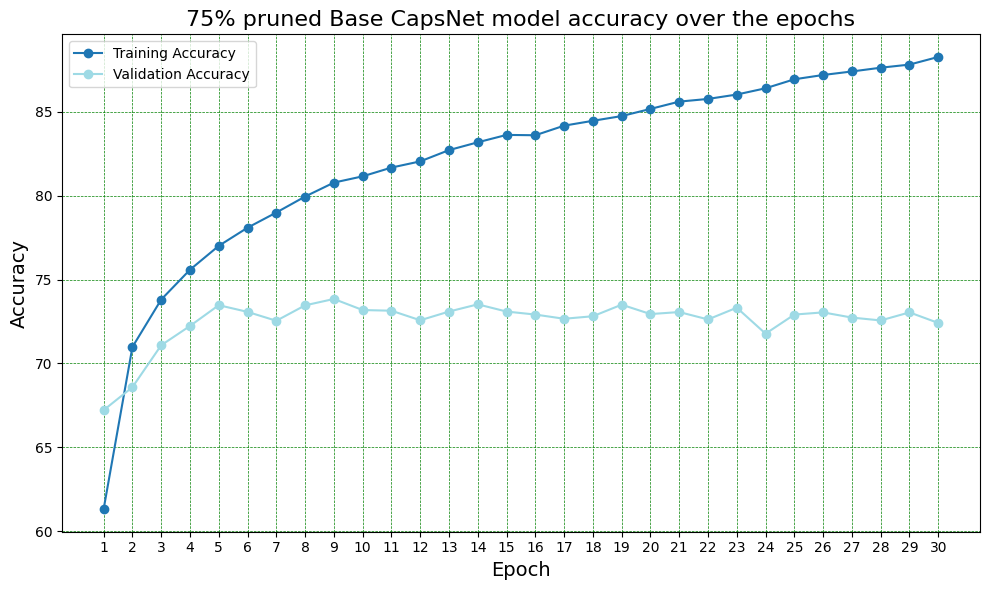

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      '75% pruned Base CapsNet model accuracy over the epochs')

#### Plots for Unpruned and Pruned CapsNet

In [ ]:
trained_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_12pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_12pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_25pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_37pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_37pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_50pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_60pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_60pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')
trained_pruned_75pc_base_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_pruned_75pc_base_capsnet_cifar10_model_Epoch30_of_30.pt')

models = [trained_base_capsnet_cifar10_model,
          trained_pruned_12pc_base_capsnet_cifar10_model,
          trained_pruned_25pc_base_capsnet_cifar10_model,
          trained_pruned_37pc_base_capsnet_cifar10_model,
          trained_pruned_50pc_base_capsnet_cifar10_model,
          trained_pruned_60pc_base_capsnet_cifar10_model,
          trained_pruned_75pc_base_capsnet_cifar10_model]

n_epochs = 30

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][1]

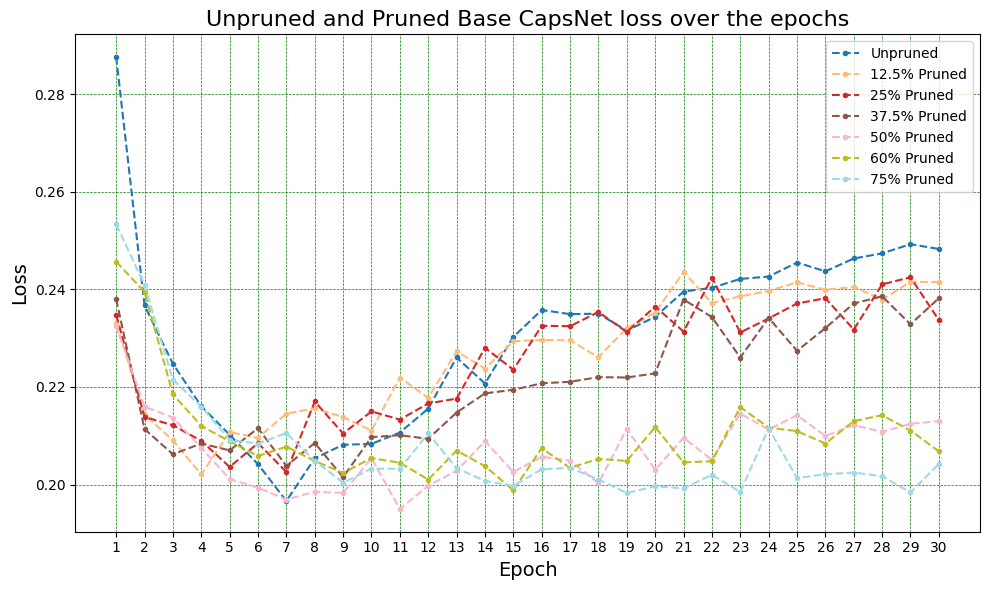

In [ ]:
utils.plot_line_chart(epoch_losses, ['Unpruned', '12.5% Pruned', '25% Pruned', '37.5% Pruned', '50% Pruned', '60% Pruned', '75% Pruned'],
                      'Epoch', 'Loss', 'Unpruned and Pruned Base CapsNet loss over the epochs', marker='.', line='--')

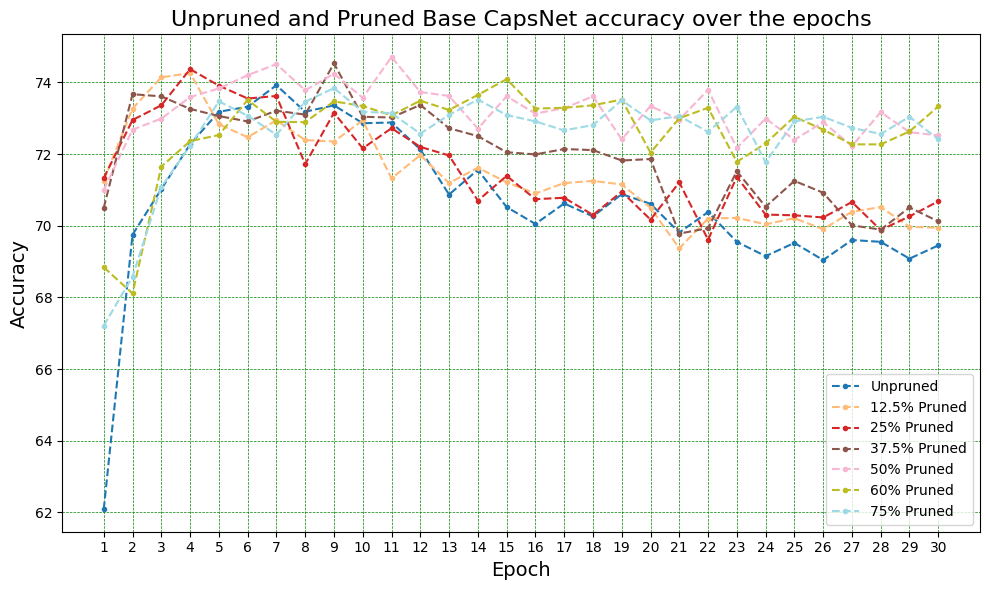

In [ ]:
utils.plot_line_chart(epoch_accuracies, ['Unpruned', '12.5% Pruned', '25% Pruned', '37.5% Pruned', '50% Pruned', '60% Pruned', '75% Pruned'],
                      'Epoch', 'Accuracy', 'Unpruned and Pruned Base CapsNet accuracy over the epochs', marker='.', line='--')

#### Flops and Params Count

In [ ]:
input_cifar10_image_size = torch.randn(1, 3, 32, 32).to(device)

In [ ]:
base_capsnet_cifar10_model.eval()

flops, params = profile(base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 Flops = {}".format(base_capsnet_cifar10_model.name, flops))
print("{} CIFAR10 Params = {}".format(base_capsnet_cifar10_model.name, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
base_capsnet_cifar10_model CIFAR10 Flops = 12796160.0
base_capsnet_cifar10_model CIFAR10 Params = 94500.0


In [ ]:
prune_threshold = 0.125
pruned_12pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_12pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_12pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_12pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_12pc_base_capsnet_cifar10_model CIFAR10 12.5% pruned Flops = 8966720.0
pruned_12pc_base_capsnet_cifar10_model CIFAR10 12.5% pruned Params = 71476.0


In [ ]:
prune_threshold = 0.25
pruned_25pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_25pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Flops = 7888896.0
pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Params = 59356.0


In [ ]:
prune_threshold = 0.375
pruned_37pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_37pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_37pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_37pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_37pc_base_capsnet_cifar10_model CIFAR10 37.5% pruned Flops = 6867520.0
pruned_37pc_base_capsnet_cifar10_model CIFAR10 37.5% pruned Params = 48388.0


In [ ]:
prune_threshold = 0.50
pruned_50pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_50pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Flops = 4027456.0
pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Params = 26148.0


In [ ]:
prune_threshold = 0.60
pruned_60pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_60pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_60pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_60pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_60pc_base_capsnet_cifar10_model CIFAR10 60.0% pruned Flops = 2503680.0
pruned_60pc_base_capsnet_cifar10_model CIFAR10 60.0% pruned Params = 16028.0


In [ ]:
prune_threshold = 0.75
pruned_60pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_75pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,))

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_75pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_75pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
pruned_75pc_base_capsnet_cifar10_model CIFAR10 75.0% pruned Flops = 2003008.0
pruned_75pc_base_capsnet_cifar10_model CIFAR10 75.0% pruned Params = 10820.0
